In [1]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

Note the location pattern on GCS : gs://downscaled-288ec5ac/diagnostics/RELEASE-v{delivery_version}/{diagnostics_name}/{activity_id}/{institution_id}/{source_id}/{experiment_id}/{member_id}/{table_id}/{variable_id}/{delivery_version}.zarr

ERA-5
gs://downscaled-288ec5ac/diagnostics/RELEASE-{delivery_version}/{diagnostics_name}/reanalysis/ERA5/F320/{variable_id}/{delivery_version}.zarr

In [2]:
'''read_gcs_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-precip-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/pr/v1.1.zarr')'''

"read_gcs_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-precip-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/pr/v1.1.zarr')"

In [3]:
plot_dir = '/gcs/impactlab-data/climate/downscaling/paper/'

In [4]:
# Set colors and markers so common to all plots.
city_aesthetics = {
    "Tokyo": ("#d60000", "o"),
    "Delhi": ("#8c3bff", "v"),
    "Shanghai": ("#018700", "^"),
    "Sao Paulo": ("#00acc6", "<"),
    "Mexico City": ("#97ff00", ">"),
    "Cairo": ("#ff7ed1", "1"),
    "Dhaka": ("#6b004f", "2"),
    "New York": ("#ffa52f", "3"),
    "Buenos Aires": ("#573b00", "4"),
    "Istanbul": ("#005659", "8"),
    "Lagos": ("#0000dd", "s"),
    "Paris": ("#00fdcf", "p"),
    "Moscow": ("#a17569", "*"),
    "Miami": ("#bcb6ff", "h"),
    "Mumbai": ("#95b577", "H"),
    "Manila": ("#bf03b8", "+"),
    "London": ("#645474", "x"),
}

In [5]:
model = 'NorESM2-LM'
institution = 'NCC'

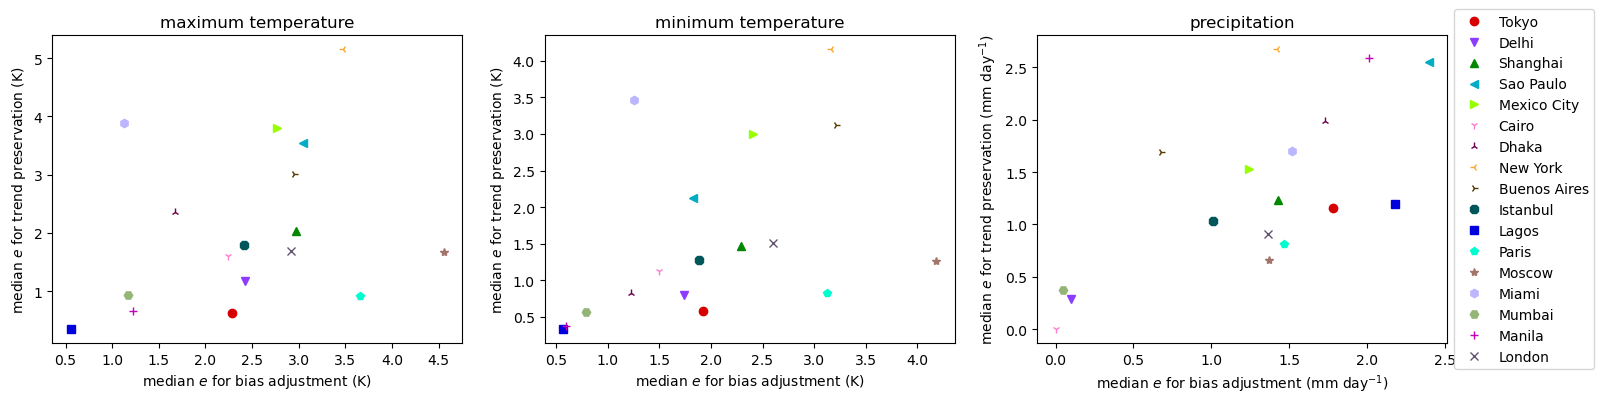

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, variable in enumerate(['tasmax', 'tasmin', 'precip']):

    if variable == "precip":
        file_var_name = "pr"
    else:
        file_var_name = variable
    
    var_ssp370_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ssp370_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ref = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/reanalysis/ERA5/F320/{}/v1.1.zarr'.format(variable, file_var_name))

    city_trend_error = {}
    city_absolute_error = {}
    for city in var_hist_clean.city.values:
        var = variable
        if variable == 'precip':
            var = 'pr'

        sim_trend = (var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).values - var_hist_clean.sel(city=city)          [var].sel(time=slice('1995', '2014')).values)
        downscale_trend = (var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).values - var_hist_ds.sel(city=city)          [var].sel(time=slice('1995', '2014')).values)
        sim_hist = (var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).values - var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).values)
        city_error = np.median(np.abs(downscale_trend - sim_trend))

        city_trend_error[city] = city_error
        abs_error = np.median(np.abs(sim_hist))
        city_absolute_error[city] = abs_error

        color, symbol = city_aesthetics[city]
        axes[i].plot(city_absolute_error[city], city_trend_error[city], symbol, c=color, label=city)
        axes[i].set_xlabel(r'median $e$ for bias adjustment (K)')
        axes[i].set_ylabel(r'median $e$ for trend preservation (K)')

        if variable == 'precip':
            title_variable = 'precipitation'
            axes[i].set_xlabel(r'median $e$ for bias adjustment (mm day$^{-1}$)')
            axes[i].set_ylabel(r'median $e$ for trend preservation (mm day$^{-1}$)')
        elif variable == 'tasmax':
            title_variable = 'maximum temperature'
        else:
            title_variable = 'minimum temperature'
        axes[i].set_title(title_variable)

axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(plot_dir, 'cities_abs_rel_daily_error.png'),
            bbox_inches='tight', dpi=200)

In [7]:
var_hist_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format("precip", "pr"))
var_hist_clean["pr"].min().compute()

<xarray.DataArray 'pr' ()>
array(0.)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

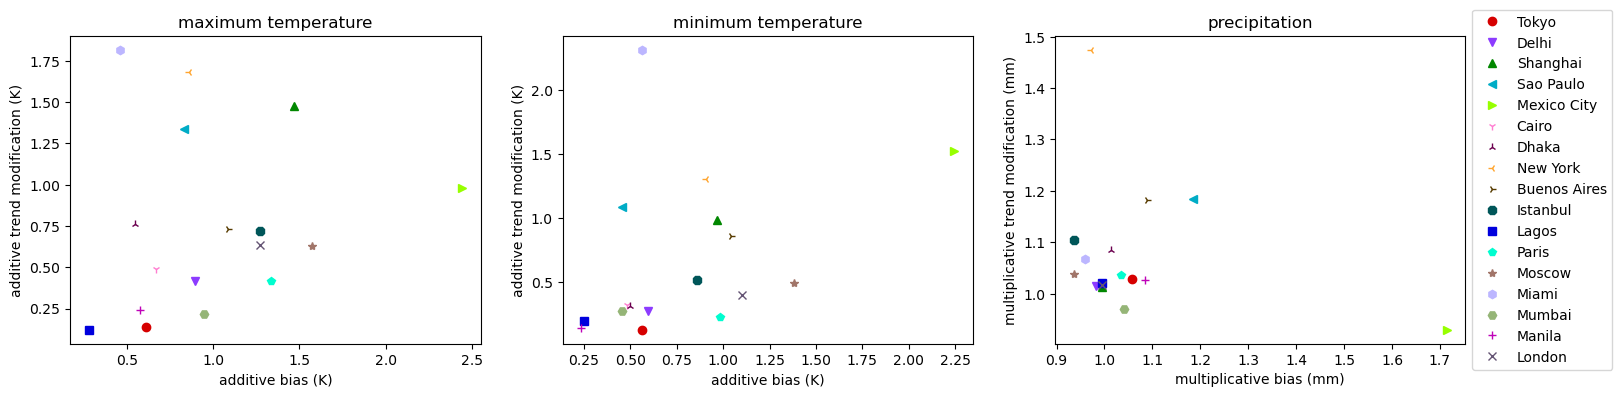

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, variable in enumerate(['tasmax', 'tasmin', 'precip']):

    if variable == "precip":
        file_var_name = "pr"
    else:
        file_var_name = variable
    
    var_ssp370_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ssp370_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ref = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/reanalysis/ERA5/F320/{}/v1.1.zarr'.format(variable, file_var_name))

    city_trend_error = {}
    city_absolute_error = {}
    for city in var_hist_clean.city.values:

        if variable == 'precip':
            var = 'pr'
        else:
            var = variable

        if variable == 'precip':
            sim_trend = var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).resample(time='QS-DEC').sum().values / var_hist_clean.sel(city=city)          [var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').sum().values

            downscale_trend = var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).resample(time='QS-DEC').sum().values / var_hist_ds.sel(city=city)          [var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').sum().values

            sim_hist = var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').sum().values / var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').sum().values

            city_error = np.median(np.abs(downscale_trend / sim_trend))
        else:

            sim_trend = var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).resample(time='QS-DEC').mean().values - var_hist_clean.sel(city=city)          [var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').mean().values

            downscale_trend = var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).resample(time='QS-DEC').mean().values - var_hist_ds.sel(city=city)          [var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').mean().values

            sim_hist = var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').mean().values - var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').mean().values

            city_error = np.median(np.abs(downscale_trend - sim_trend))


        city_trend_error[city] = city_error
        abs_error = np.median(np.abs(sim_hist))

        city_absolute_error[city] = abs_error

        color, symbol = city_aesthetics[city]

        axes[i].plot(city_absolute_error[city], city_trend_error[city], symbol, c=color, label=city)
        axes[i].set_ylabel('additive trend modification (K)')
        axes[i].set_xlabel('additive bias (K)')
        # axes[i].set_ylim([0, 2.5])
        # axes[i].set_aspect(aspect="equal", share=True)

        axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if variable == 'precip': 
            title_variable = 'precipitation'
            axes[i].set_ylabel('multiplicative trend modification (mm)')
            axes[i].set_xlabel('multiplicative bias (mm)')
        elif variable == 'tasmax':
            title_variable = 'maximum temperature'
        else:
            title_variable = 'minimum temperature'
        axes[i].set_title(title_variable)

plt.savefig(os.path.join(plot_dir, 'cities_abs_rel_seasonal_error.png'), 
            bbox_inches='tight', dpi=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


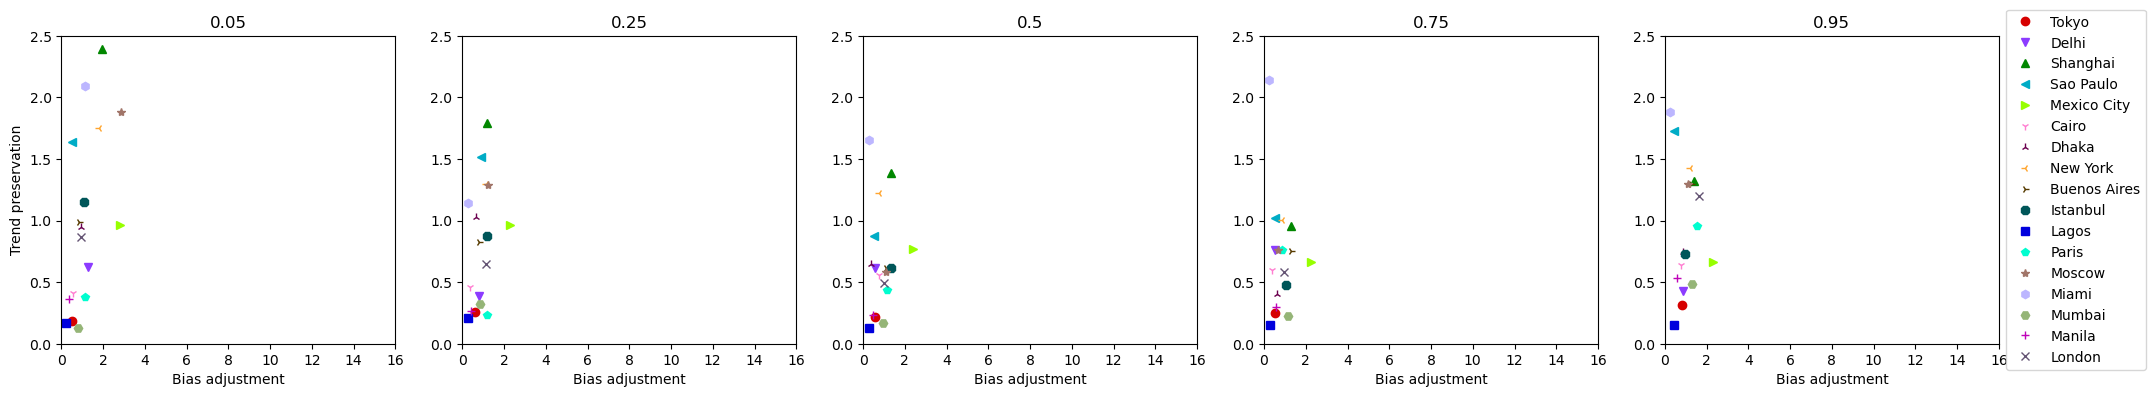

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i, q in enumerate([0.05, 0.25, 0.5, 0.75, 0.95]):
    variable = 'tasmax'
    
    
    if variable == "precip":
        file_var_name = "pr"
    else:
        file_var_name = variable
    
    var_ssp370_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ssp370_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ref = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/reanalysis/ERA5/F320/{}/v1.1.zarr'.format(variable, file_var_name))

    city_trend_error = {}
    city_absolute_error = {}
    for city in var_hist_clean.city.values:
        
        if variable == 'precip':
            var = 'pr'
        else:
            var = variable 

        sim_trend = (var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).groupby('time.year').quantile(q).values 
                     - var_hist_clean.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values)

        downscale_trend = (var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).groupby('time.year').quantile(q).values 
                           - var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values)

        city_error = np.median(np.abs(downscale_trend - sim_trend))
        city_trend_error[city] = city_error

        sim_hist = (var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values 
                    - var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values)

        abs_error = np.median(np.abs(sim_hist))

        city_absolute_error[city] = abs_error

        color, symbol = city_aesthetics[city]
        axes[i].plot(city_absolute_error[city], city_trend_error[city], symbol, c=color, label=city)
    axes[i].set_xlabel('Bias adjustment')
    axes[i].set_xlim([0, 16])
    axes[i].set_ylim([0, 2.5])
    axes[0].set_ylabel('Trend preservation')
    
    axes[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    axes[i].set_title('{}'.format(q))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


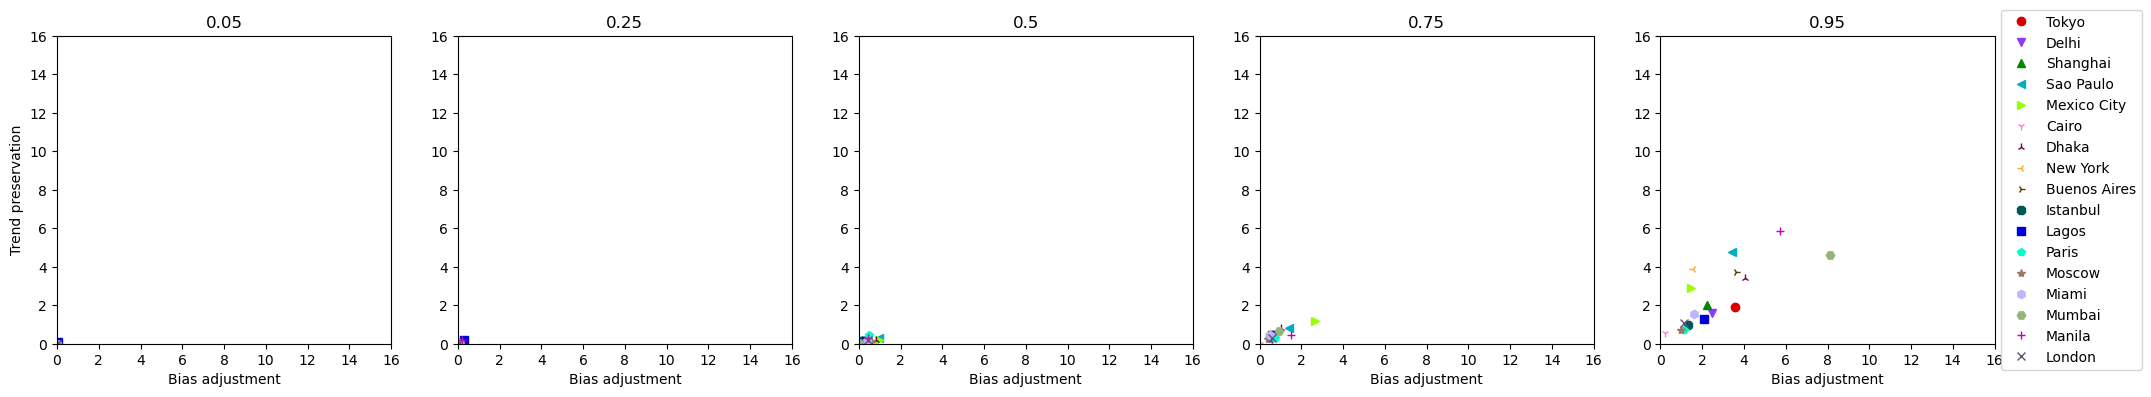

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i, q in enumerate([0.05, 0.25, 0.5, 0.75, 0.95]):
    variable = 'precip'
    
    
    if variable == "precip":
        file_var_name = "pr"
    else:
        file_var_name = variable
    
    var_ssp370_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ssp370_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ref = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/reanalysis/ERA5/F320/{}/v1.1.zarr'.format(variable, file_var_name))

    city_trend_error = {}
    city_absolute_error = {}
    for city in var_hist_clean.city.values:
        
        if variable == 'precip':
            var = 'pr'
        else:
            var = variable 

        sim_trend = (var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).groupby('time.year').quantile(q).values 
                     - var_hist_clean.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values)

        downscale_trend = (var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).groupby('time.year').quantile(q).values 
                           - var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values)

        city_error = np.median(np.abs(downscale_trend - sim_trend))
        city_trend_error[city] = city_error

        sim_hist = (var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values 
                    - var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values)

        abs_error = np.median(np.abs(sim_hist))

        city_absolute_error[city] = abs_error

        color, symbol = city_aesthetics[city]
        axes[i].plot(city_absolute_error[city], city_trend_error[city], symbol, c=color, label=city)
    axes[i].set_xlabel('Bias adjustment')
    axes[i].set_xlim([0, 16])
    axes[i].set_ylim([0, 16])
    axes[0].set_ylabel('Trend preservation')
    
    axes[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    axes[i].set_title('{}'.format(q))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


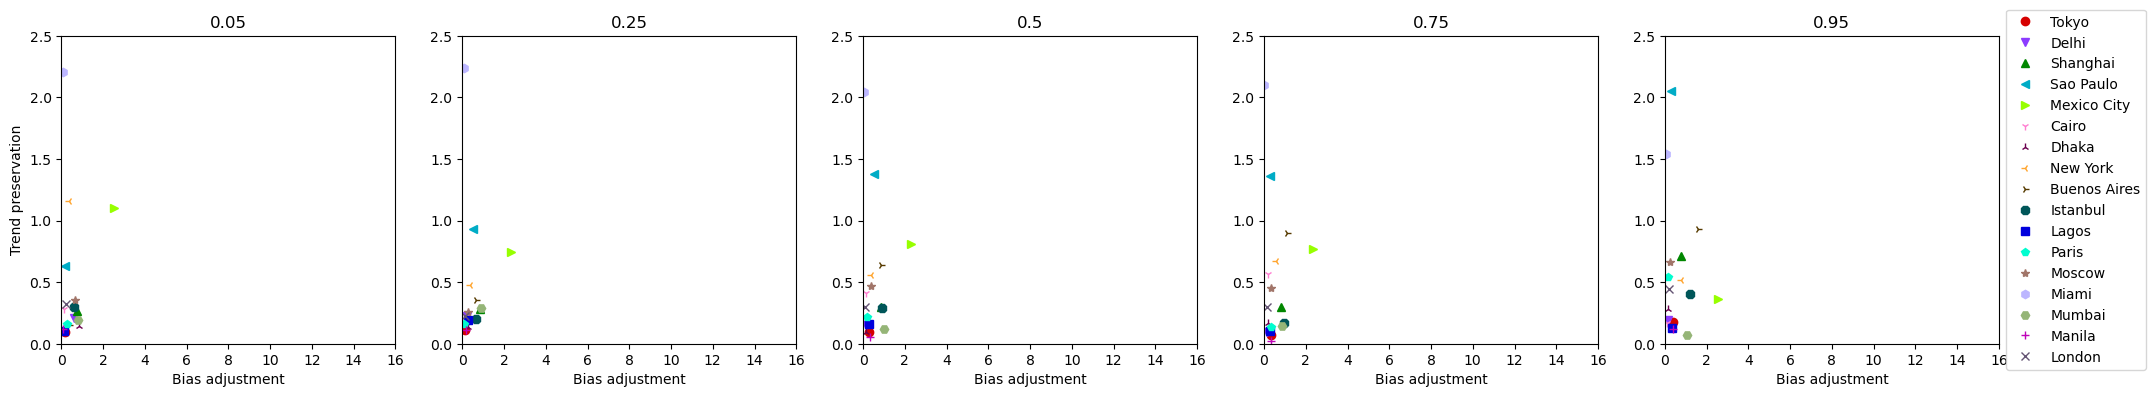

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i, q in enumerate([0.05, 0.25, 0.5, 0.75, 0.95]):
    variable = 'tasmax'
    
    
    if variable == "precip":
        file_var_name = "pr"
    else:
        file_var_name = variable
    
    var_ssp370_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ssp370_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ref = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/reanalysis/ERA5/F320/{}/v1.1.zarr'.format(variable, file_var_name))

    city_trend_error = {}
    city_absolute_error = {}
    for city in var_hist_clean.city.values:
        
        if variable == 'precip':
            var = 'pr'
        else:
            var = variable 

        sim_trend = (var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values 
                     - var_hist_clean.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values)

        downscale_trend = (var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values 
                           - var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values)

        city_error = np.median(np.abs(downscale_trend - sim_trend))
        city_trend_error[city] = city_error

        sim_hist = (var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values 
                    - var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values)

        abs_error = np.median(np.abs(sim_hist))

        city_absolute_error[city] = abs_error

        color, symbol = city_aesthetics[city]
        axes[i].plot(city_absolute_error[city], city_trend_error[city], symbol, c=color, label=city)
    axes[i].set_xlabel('Bias adjustment')
    axes[i].set_xlim([0, 16])
    axes[i].set_ylim([0, 2.5])
    axes[0].set_ylabel('Trend preservation')
    
    axes[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    axes[i].set_title('{}'.format(q))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


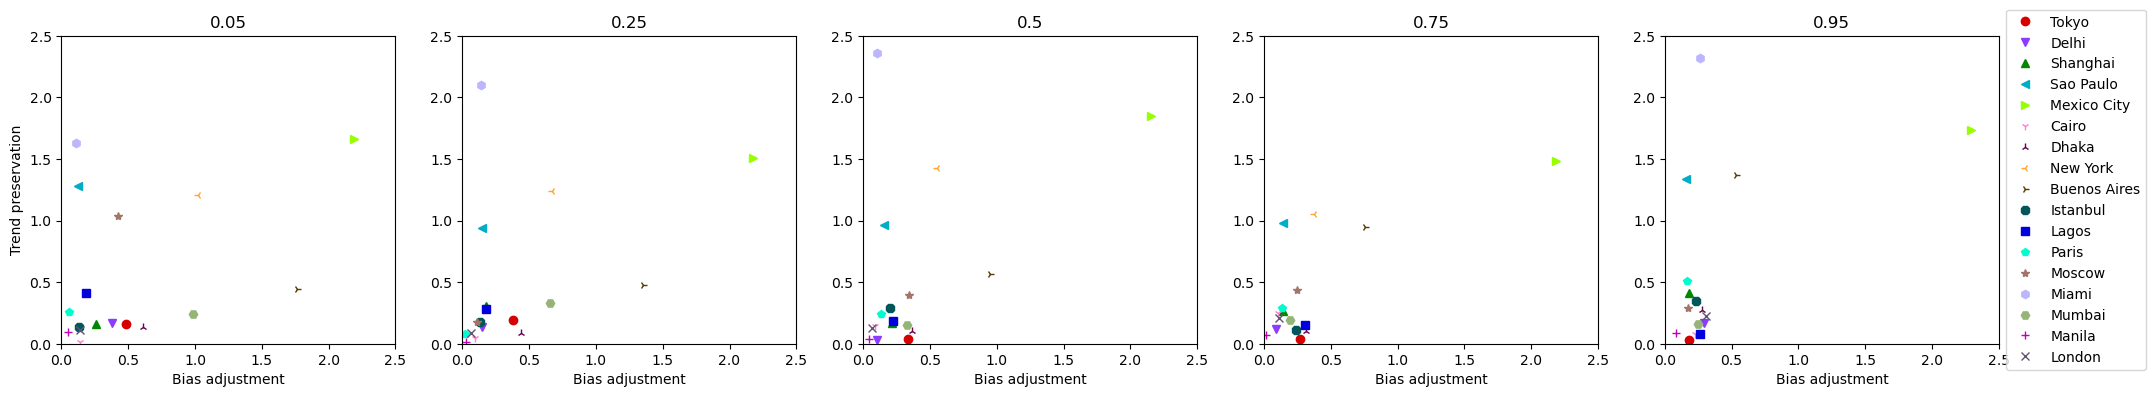

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i, q in enumerate([0.05, 0.25, 0.5, 0.75, 0.95]):
    variable = 'tasmin'
    
    
    if variable == "precip":
        file_var_name = "pr"
    else:
        file_var_name = variable
    
    var_ssp370_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ssp370_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ref = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/reanalysis/ERA5/F320/{}/v1.1.zarr'.format(variable, file_var_name))

    city_trend_error = {}
    city_absolute_error = {}
    for city in var_hist_clean.city.values:
        
        if variable == 'precip':
            var = 'pr'
        else:
            var = variable 

        sim_trend = (var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values 
                     - var_hist_clean.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values)

        downscale_trend = (var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values 
                           - var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values)

        city_error = np.median(np.abs(downscale_trend - sim_trend))
        city_trend_error[city] = city_error

        sim_hist = (var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values 
                    - var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values)

        abs_error = np.median(np.abs(sim_hist))

        city_absolute_error[city] = abs_error

        color, symbol = city_aesthetics[city]
        axes[i].plot(city_absolute_error[city], city_trend_error[city], symbol, c=color, label=city)
    axes[i].set_xlabel('Bias adjustment')
    axes[i].set_xlim([0, 2.5])
    axes[i].set_ylim([0, 2.5])
    axes[0].set_ylabel('Trend preservation')
    
    axes[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    axes[i].set_title('{}'.format(q))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


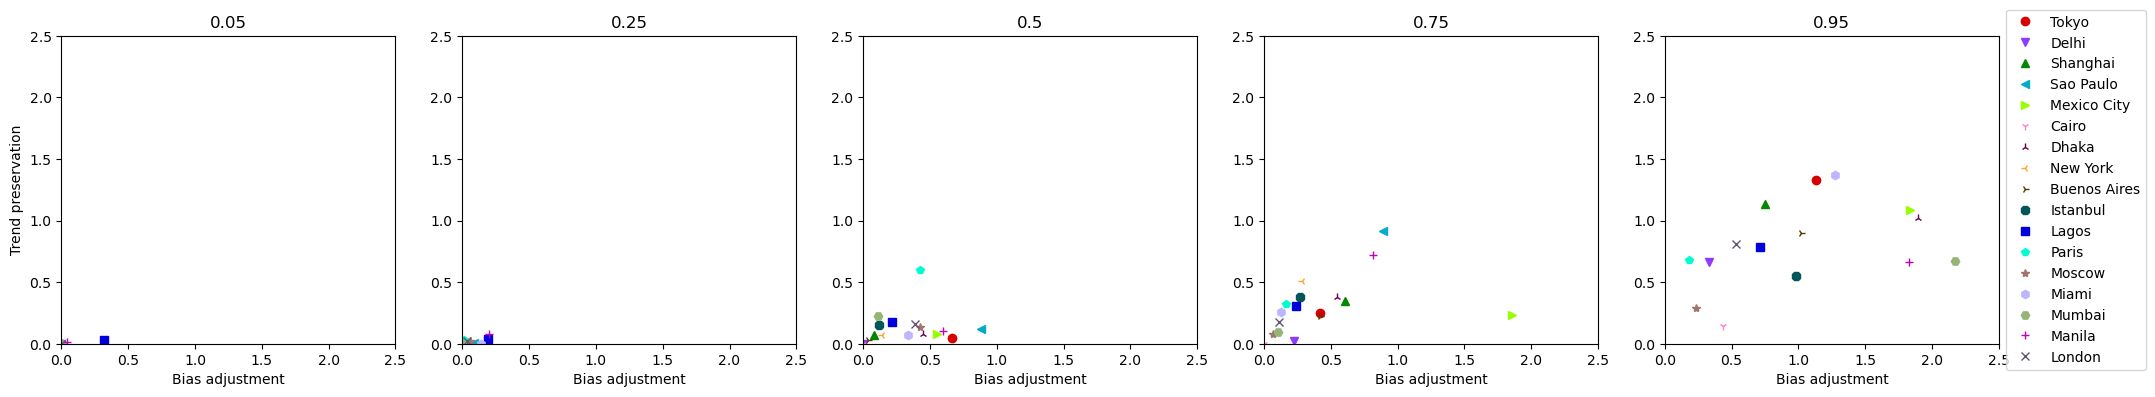

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i, q in enumerate([0.05, 0.25, 0.5, 0.75, 0.95]):
    variable = 'precip'
    
    
    if variable == "precip":
        file_var_name = "pr"
    else:
        file_var_name = variable
    
    var_ssp370_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ssp370_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ref = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/reanalysis/ERA5/F320/{}/v1.1.zarr'.format(variable, file_var_name))

    city_trend_error = {}
    city_absolute_error = {}
    for city in var_hist_clean.city.values:
        
        if variable == 'precip':
            var = 'pr'
        else:
            var = variable 

        sim_trend = (var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values 
                     - var_hist_clean.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values)

        downscale_trend = (var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values 
                           - var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values)

        city_error = np.median(np.abs(downscale_trend - sim_trend))
        city_trend_error[city] = city_error

        sim_hist = (var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values 
                    - var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).chunk(dict(time=-1)).groupby('time.season').quantile(q).values)

        abs_error = np.median(np.abs(sim_hist))

        city_absolute_error[city] = abs_error

        color, symbol = city_aesthetics[city]
        axes[i].plot(city_absolute_error[city], city_trend_error[city], symbol, c=color, label=city)
    axes[i].set_xlabel('Bias adjustment')
    axes[i].set_xlim([0, 2.5])
    axes[i].set_ylim([0, 2.5])
    axes[0].set_ylabel('Trend preservation')
    
    axes[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    axes[i].set_title('{}'.format(q))

Text(0.5, 1.0, 'tasmax')

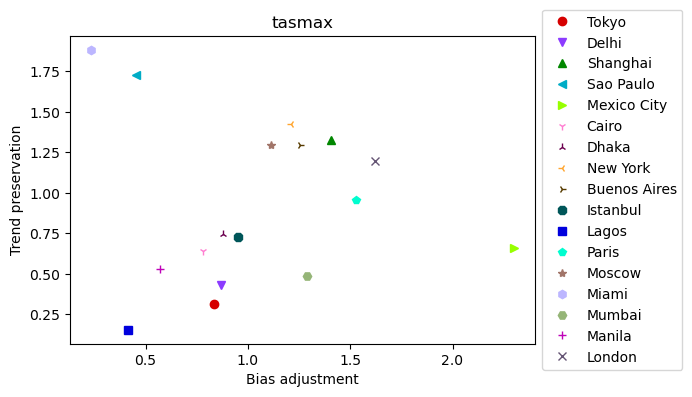

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

variable = 'tasmax'
    
if variable == "precip":
    file_var_name = "pr"
else:
    file_var_name = variable

var_ssp370_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
var_hist_ds = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

var_ssp370_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
var_hist_clean = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

var_ref = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/reanalysis/ERA5/F320/{}/v1.1.zarr'.format(variable, file_var_name))

city_trend_error = {}
city_absolute_error = {}
for city in var_hist_clean.city.values:

    if variable == 'precip':
        var = 'pr'
    else:
        var = variable 
    q = 0.95
    sim_trend = (var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).groupby('time.year').quantile(q).values 
                 - var_hist_clean.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values)

    downscale_trend = (var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).groupby('time.year').quantile(q).values 
                       - var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values)

    city_error = np.median(np.abs(downscale_trend - sim_trend))
    city_trend_error[city] = city_error

    sim_hist = (var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values 
                - var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).groupby('time.year').quantile(q).values)

    abs_error = np.median(np.abs(sim_hist))

    city_absolute_error[city] = abs_error

    color, symbol = city_aesthetics[city]
    axes.plot(city_absolute_error[city], city_trend_error[city], symbol, c=color, label=city)
axes.set_xlabel('Bias adjustment')
axes.set_ylabel('Trend preservation')

axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes.set_title(variable)


In [15]:
city_trend_error

{'Tokyo': 0.31568603515626137,
 'Delhi': 0.4277252197265682,
 'Shanghai': 1.3241149902343636,
 'Sao Paulo': 1.7253387451171989,
 'Mexico City': 0.6604888916016023,
 'Cairo': 0.6393493652343807,
 'Dhaka': 0.7452453613281023,
 'New York': 1.425595092773392,
 'Buenos Aires': 1.293499755859358,
 'Istanbul': 0.7267517089843807,
 'Lagos': 0.1541687011718409,
 'Paris': 0.9532104492187727,
 'Moscow': 1.2977447509765625,
 'Miami': 1.8842346191406136,
 'Mumbai': 0.48613281249998863,
 'Manila': 0.5316741943359773,
 'London': 1.1957885742187386}